# Artificial neural networks and their applications project 

# Assesment of Deep NNs on different Out of Distribution datasets in deep CNN
Made by Suleimanov Nikhat and Kirill Golubev

Importing the necessary libraries

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
from torchsummary import summary
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
torch.manual_seed(0)

2024-05-13 03:48:04.194431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Downloading and Loading FashionMNIST dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])


train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

training_images = np.zeros((len(train_data), 28, 28))
training_labels = np.zeros(len(train_data), dtype=int)

for i, (img, label) in enumerate(train_data):
    training_images[i] = img.numpy()
    training_labels[i] = int(label)

testing_images = np.zeros((len(test_data), 28, 28))
testing_labels = np.zeros(len(test_data), dtype = int)

for i, (img, label) in enumerate(test_data):
    testing_images[i] = img.numpy()
    testing_labels[i] = int(label)
print('Training Data: X=%s, y=%s' % (training_images.shape, training_labels.shape))
print('Testing Data : X=%s, y=%s' % (testing_images.shape, testing_labels.shape))
print('(Data is normalized between 0 and 1 because of transform function)')

Training Data: X=(60000, 28, 28), y=(60000,)
Testing Data : X=(10000, 28, 28), y=(10000,)
(Data is normalized between 0 and 1 because of transform function)


Data Cleansing

In [4]:
t1 = np.isnan(training_images).any()
t2 = np.isnan(training_labels).any()

if(not t1 and not t2):
	print('Data is clean')

X_train_all = training_images.astype('float32')
X_test  = testing_images.astype('float32')

Data is clean


Splitting the training dataset to train and validation datasets

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, training_labels, stratify=training_labels, test_size=0.2, random_state=42)

print("Splitting the training dataset into training and validation (80% Train and 20% Validation)")
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, testing_labels.shape))

Splitting the training dataset into training and validation (80% Train and 20% Validation)
Train: X=(48000, 28, 28), y=(48000,)
val  : X=(12000, 28, 28), y=(12000,)
Test : X=(10000, 28, 28), y=(10000,)


Some Data Analysis (cred. to Ksaraswat)

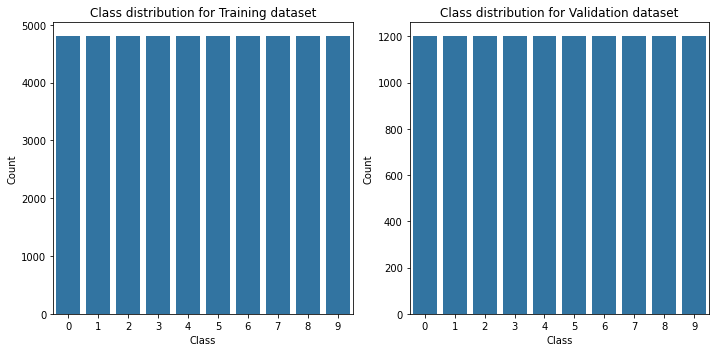

In [6]:
import seaborn as sns
import pandas as pd

# Create separate Series for each dataset
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
testing_labels_series = pd.Series(testing_labels)

# Calculate value counts for each dataset
class_counts_train = y_train_series.value_counts()
class_counts_val = y_val_series.value_counts()
class_counts_test = testing_labels_series.value_counts()

# Plotting class distributions for each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=class_counts_train.index, y=class_counts_train.values)
plt.title("Class distribution for Training dataset")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.barplot(x=class_counts_val.index, y=class_counts_val.values)
plt.title("Class distribution for Validation dataset")
plt.xlabel("Class")
plt.ylabel("Count")



plt.tight_layout()
plt.show()

Visualisation

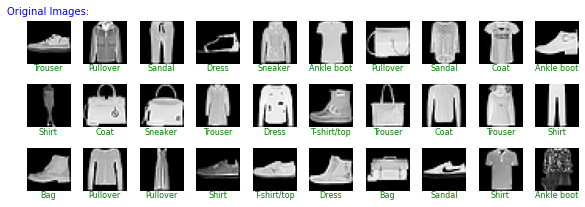

In [7]:
# Visualizing Plot examples from classes
import matplotlib.pyplot as plt

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Randomly select 30 images from train dataset to visualize
num_images_to_display = 30
random_indexes = np.random.randint(0, X_train.shape[0], num_images_to_display)

# Create a figure with a grid of subplots
plt.figure(figsize=(8, 6))  # Adjust overall figure size

for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')



# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Principal Component Analysis

Flatten the images to 1-D by reshaping

In [8]:
X_train_all = X_train_all.reshape(60000,784)
X_train = X_train.reshape(48000,784)
X_val   = X_val.reshape(12000,784)
X_test  = X_test.reshape(10000,784)

print("Training and validation matrix combined shape  :", X_train_all.shape)
print("Training matrix shape  :", X_train.shape)
print("Validation matrix shape:", X_val.shape)
print("Test matrix shape      :", X_test.shape)


Training and validation matrix combined shape  : (60000, 784)
Training matrix shape  : (48000, 784)
Validation matrix shape: (12000, 784)
Test matrix shape      : (10000, 784)


Performing PCA on both training and validation data combined

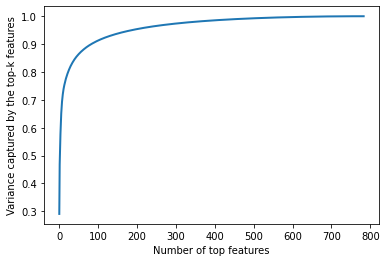

<Axes: >

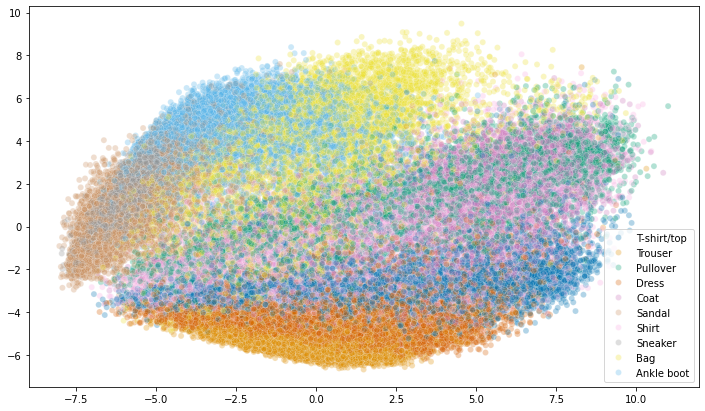

In [9]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components = 784)
pca_fit = pca_all.fit_transform(X_train_all)# Fit on training data
ratio_variance = np.cumsum(pca_all.explained_variance_ratio_) #percentage variance explained
pca_fit.shape

# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(ratio_variance, linewidth=2)
plt.xlabel("Number of top features")
plt.ylabel("Variance captured by the top-k features")
plt.show()

pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

label_mapping = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

def map_to_label(value):
    return label_mapping.get(int(value), 'Unknown')

# Apply the mapping function element-wise to the array
labels = np.vectorize(map_to_label)(training_labels)

# Plotting the data based on first two principle components
plt.figure(figsize=(12,7))
import seaborn as sns
sns.scatterplot(
    x=pca_fit[:,0], y=pca_fit[:,1],
    hue = labels,
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3
)

Reshaping the Data into original size

In [10]:
from sklearn.manifold import TSNE

X_train_t = pca.transform(X_train)
X_val_t   = pca.transform(X_val)
X_test_t  = pca.transform(X_test)

X_train_i = pca.inverse_transform(X_train_t)
X_val_i   = pca.inverse_transform(X_val_t)
X_test_i  = pca.inverse_transform(X_test_t)

training_images = X_train.reshape(48000,28,28)
reduced_training_images = X_train_i.reshape(48000,28,28)

Plotting the data after PCA

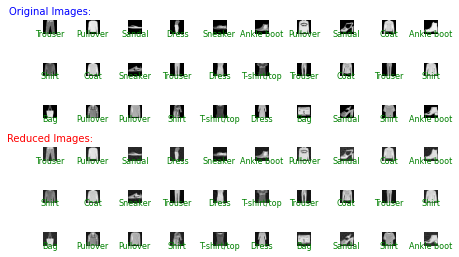

In [11]:
for i, index in enumerate(random_indexes, 1):
    # Original image
    plt.subplot(6, 10, i)
    plt.imshow(training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Original Images:", fontsize=10, color='blue')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

    # Reduced image
    plt.subplot(6, 10, i + num_images_to_display)
    plt.imshow(reduced_training_images[index], cmap='gray', extent=[0, 1.5, 0, 1.5])
    if i == 1:
        # Set the title for the section
        plt.title("Reduced Images:", fontsize=10, color='red')
    plt.axis('off')
    # Add the label below the image with adjusted position
    plt.text(0.75, -0.25, class_names[y_train[index]], ha='center', fontsize=8, color='green')

# Adjust the placement of the title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

t-Distributed Stochastic Neighbouring Entities

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


<Axes: >

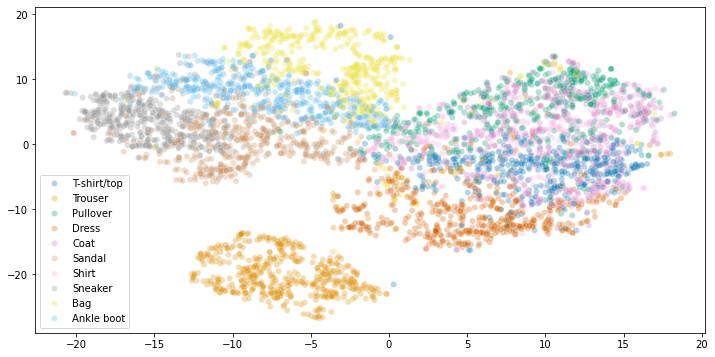

In [12]:
tsne = TSNE(n_components=3) # Invoking the t-SNE method
tsne_dt = X_train_all[:5000]
tsne_results = tsne.fit_transform(tsne_dt)

plt.figure(figsize=(12,6))
sns.scatterplot(x = tsne_results[:,0],
    y = tsne_results[:,1],
    hue=labels[:5000],
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3)

Building the Neural Network

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)
        ###### split
        self.cnn = nn.Sequential(
            self.make_cnn_block(1, 16, 3),
            nn.MaxPool2d(2,2),
            self.make_cnn_block(16, 32, 3),
            self.make_cnn_block(32, 64, 3),
            nn.MaxPool2d(2,2),
            self.make_cnn_block(64, 128, 3,final_layer = True),
        )
        self.fnn = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,10)
        )


    def make_cnn_block(self, input_channels, output_channels, kernel_size=3, stride=1, padding = 0, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding = padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
# New functions here
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', 
                               restore_best_weights=True)

def monte_carlo_prediction(model, input, num_samples=100):
    model.train()  # Keep the model in training mode to use dropout
    predictions = [model(input) for _ in range(num_samples)]
    return torch.stack(predictions)

def softmax_with_temperature(logits, temperature=1.0):
    e_x = torch.exp(logits / temperature)
    return e_x / e_x.sum(dim=-1, keepdim=True)

def is_ood(softmax_probs, threshold=0.8):
    max_probs, _ = torch.max(softmax_probs, dim=1)
    return max_probs < threshold
#####################

# Creating TensorDatasets and DataLoaders
X_train_cnn = torch.tensor(X_train.reshape(-1,1,28,28)).float()
y_train_cnn = torch.tensor(y_train).long()
X_val_cnn   = torch.tensor(X_val.reshape(-1,1,28,28)).float()
y_val_cnn   = torch.tensor(y_val).long()
X_test_cnn  = torch.tensor(X_test.reshape(-1,1,28,28)).float()
y_test_cnn  = torch.tensor(testing_labels).long()


train_dataset = TensorDataset(X_train_cnn, y_train_cnn)
val_dataset   = TensorDataset(X_val_cnn, y_val_cnn)
test_dataset  = TensorDataset(X_test_cnn, y_test_cnn)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min',     ###########
                               restore_best_weights=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#####################

model = CNN()
# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the model

In [15]:
# Training loop
num_epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

#####################

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train_preds += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train_preds / len(train_dataset)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            correct_val_preds += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val_preds / len(val_dataset)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_cnn_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/5], Training Loss: 0.3257, Validation Loss: 0.2798, Training Accuracy: 0.8790, Validation Accuracy: 0.8972
Epoch [2/5], Training Loss: 0.2844, Validation Loss: 0.2490, Training Accuracy: 0.8939, Validation Accuracy: 0.9097
Epoch [3/5], Training Loss: 0.2502, Validation Loss: 0.2379, Training Accuracy: 0.9073, Validation Accuracy: 0.9098
Epoch [4/5], Training Loss: 0.2326, Validation Loss: 0.2216, Training Accuracy: 0.9118, Validation Accuracy: 0.9187
Epoch [5/5], Training Loss: 0.2153, Validation Loss: 0.2148, Training Accuracy: 0.9194, Validation Accuracy: 0.9213


Plotting training history

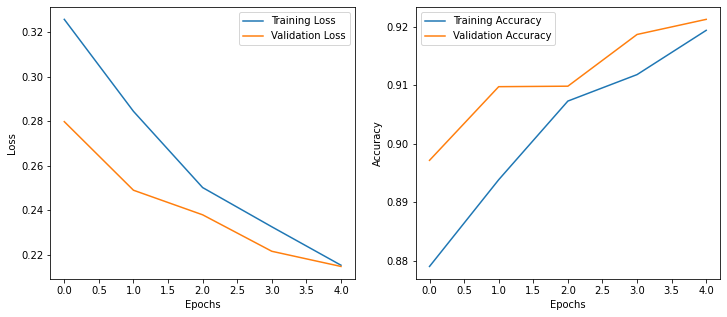

In [16]:
###

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Evaluating

In [17]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


# Initialize your Convolution neural network class
model = CNN()
# Load the saved best model weights
model.load_state_dict(torch.load('best_cnn_model.pth'))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# def plot_learning_curves(history):            
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, acc, 'bo', label='Training acc')
#     plt.plot(epochs, val_acc, 'b', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, loss, 'bo', label='Training loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

#     plt.show()

Tests with different evaluations

Testing Temperature Scaling and OOD Detection Functions

In [18]:
# Set the model to evaluation mode

model.eval()
with torch.no_grad():        
    for images, _ in test_loader:
        logits = model(images)
        softmax_probs = softmax_with_temperature(logits, temperature=1.0)
        ood_flags = is_ood(softmax_probs, threshold=0.8)
        print("OOD Flags:", ood_flags)

OOD Flags: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True,  True, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False,  True, False, False, False,  True, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, Fal

Testing Monte Carlo Dropout

In [20]:
model.eval()
with torch.no_grad():        
    for images, labels in test_loader:
        mc_predictions = monte_carlo_prediction(model, images, num_samples=50)
        # Calculate the mean and variance of the predictions
        prediction_means = torch.mean(mc_predictions, dim=0)  # [batch_size, num_classes]
        prediction_variances = torch.var(mc_predictions, dim=0)  # [batch_size, num_classes]

        # Optionally, find the max probabilities and their corresponding classes
        max_probs, max_indices = torch.max(prediction_means, dim=1)
        true_classes = labels

        # Print the analysis results
        print("Mean Predictions:\n", prediction_means)
        print("Prediction Variances:\n", prediction_variances)
        print("Predicted Classes:\n", max_indices)
        print("Actual Classes:\n", true_classes)
        
        # Evaluate and print accuracy
        correct_predictions = (max_indices == true_classes).float().sum()
        accuracy = correct_predictions / images.size(0)
        print("Batch Accuracy: {:.2%}".format(accuracy.item()))
        
        # Optionally, analyze high variance predictions as potential OOD samples
        high_variance_mask = prediction_variances.max(dim=1).values > 0.05  # Threshold to adjust based on your observations
        print("High variance (potential OOD) predictions count:", high_variance_mask.sum().item())

Mean Predictions:
 tensor([[ -4.3123,  -8.7649,  -8.1497,  ...,   1.3496,  -5.0927,  11.1477],
        [ -1.8208,  -9.4883,   7.0804,  ..., -10.9867,  -8.2683,  -6.4533],
        [ -3.1717,  17.6934,  -5.3336,  ..., -18.6540,  -8.4499, -15.8190],
        ...,
        [  7.9382,  -6.7473,  -1.2138,  ..., -12.7841,  -6.1262, -10.9941],
        [ -5.6006,  -9.1147,  -7.0177,  ...,  -4.9535,  17.9338,  -4.0881],
        [ -2.9080,  -8.8755,   2.8535,  ..., -11.3401,  -5.1493,  -7.8715]])
Prediction Variances:
 tensor([[0.3990, 0.9711, 0.5580,  ..., 0.8398, 1.3789, 1.2512],
        [0.5090, 0.9330, 0.6357,  ..., 1.0698, 1.3172, 0.8290],
        [1.3409, 4.5507, 1.3536,  ..., 3.7212, 3.1143, 2.7862],
        ...,
        [0.7165, 1.3379, 0.9396,  ..., 1.4791, 0.6399, 0.9359],
        [1.4876, 3.0040, 1.6719,  ..., 2.2116, 4.8528, 2.4730],
        [0.7890, 1.3468, 0.4716,  ..., 1.5794, 1.0881, 1.0094]])
Predicted Classes:
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2,

Default testing

In [21]:
model.eval()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

Compute confusion matrix

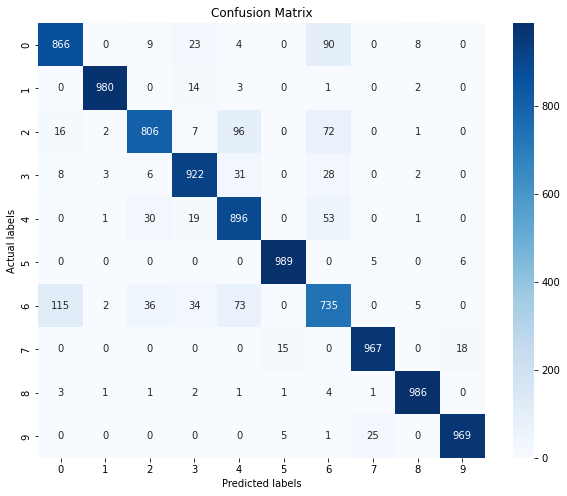

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.91      0.81      0.85      1000
           3       0.90      0.92      0.91      1000
           4       0.81      0.90      0.85      1000
           5       0.98      0.99      0.98      1000
           6       0.75      0.73      0.74      1000
           7       0.97      0.97      0.97      1000
           8       0.98      0.99      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [22]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

print(classification_report(true_labels, predictions))